# Introduction to time series analysis

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marialonsogar/Introduction-to-Time-Series/blob/main/lessons/01-Introduction.ipynb)
[![nbviewer](https://img.shields.io/badge/render-nbviewer-orange.svg)](https://nbviewer.org/github/marialonsogar/Introduction-to-Time-Series/blob/main/lessons/01-Introduction.ipynb)

# Table of contents
* [1. Introduction](#chapter1)
* [2. Time series examples](#chapter2)
* [3. Objectives of time series analysis](#chapter3)
* [4. Classification of time series](#chapter4)
* [5. Simple descriptive techniques](#chapter5)
    * [5.1 Trend, seasonal patterns, cyclical changes, remaining irregular fluctuations](#chapter5)
    * [5.2 ACF and PACF plots](#section5_2)
    * [5.3 Decomposition](#section5_3)
* [6. Stationary time series](#chapter6)
    * [6.1 Tests for checking stationarity](#section6_1)
    * [6.2 Tests for checking seasonal stationarity](#section6_2)
    * [6.3 Example: White noise](#section6_3)
        * [6.3.1 Test for identifying white noise](#section6_3_1)
* [7. Normality](#chapter7)
    * [7.1 Test for checking normality](#section7_1)
* [8. Transformations](#chapter8)
    * [8.1 Log and Box-Cox transformations](#section8_1)
    * [8.2 Filters: moving average and differencing](#section8_2)
* [Summary](#summary)

# Introduction<a class="anchor" id="chapter1"></a>

A **time series** is a time-oriented or chronological sequence of observations on a variable of interest. (Formally, a time series is a collection of random variables ordered according to the time instant at which they are collected: $\{y_1, y_2, ...\}$, where $y_i$ denotes the value of the random variable at time $i$. Therefore, a time series is a realization of a stochastic process $\{y_t\}$, $t=1,2,...$). 


**Forecasting vs Supervised regression**

A common mistake is to treat a time series analysis problem as a supervised regression problem. Both are intended to predict numbers, but they are not the same type of problem: 
- In supervised regression, we predict label/target variables from feature variables, in a cross-sectional set-up. This is after training on label/feature random samples of independent observations. 
- In forecasting, we predict future values from past values, of the same variable, in a temporal/sequential set-up. This is after training on the past.

<span style="color:grey"> The detailed exposition can be found in [The pitfalls of mis-diagnosing forecasting as supervised regression](https://github.com/alan-turing-institute/sktime/blob/main/examples/01a_forecasting_sklearn.ipynb).</span>

In fact, the main characteristic of a time series is that consecutive observations are **not** usually independent, but are correlated and it is necessary to take into account the time **order** in the analysis.

### Package imports

In [1]:
# data handling
import pandas as pd
import numpy as np

# time series handling
from sktime.datasets import load_airline

# visualization
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Time series examples <a class="anchor" id="chapter2"></a>

To get an idea of what a time series is, we will start by giving a number of examples. 

1. **Economic time series**

Examples of economic time series include share prices on successive days, average incomes in successive months, company profits in succesive years, etc. 

Below is the classic Beveridge wheat price index series, which represents the average wheat price of almost 50 different locations from the year 1500 to 1869.

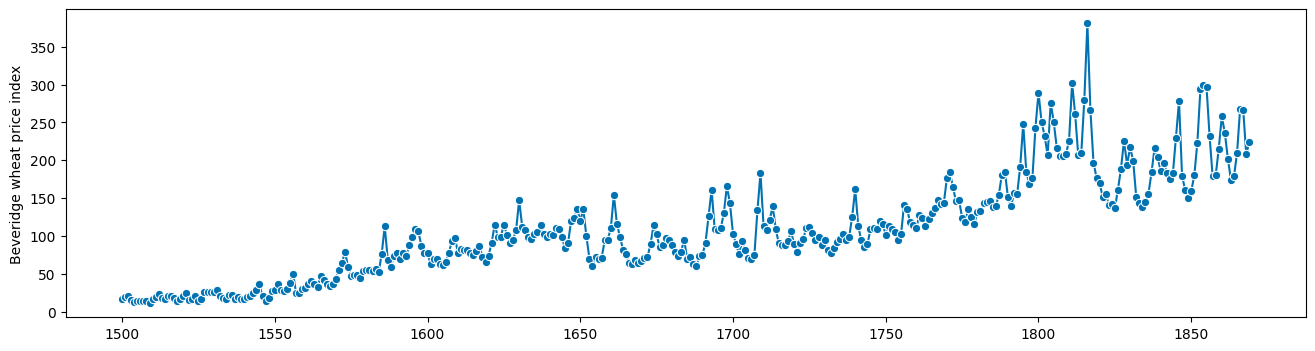

In [2]:
beveridge = pd.read_csv('..\data\\beveridge.csv', index_col=0)
beveridge = pd.Series(beveridge['Beveridge wheat price index'])
plot_series(beveridge) # plot series
plt.show()

2. **Physical time series**

Some time series are generated by physical processes, such as meteorological or geophysical phenomena. Examples are rainfall on successive days, air temperature measured in successive hours, days or months. 

The figure below shows deviations of global mean land-ocean temperature index from 1880 to 2009 from the 1951-1980 temperature average. There has been an upward trend since the end of the 20th century, which has been used as an argument in favor of climate change. 

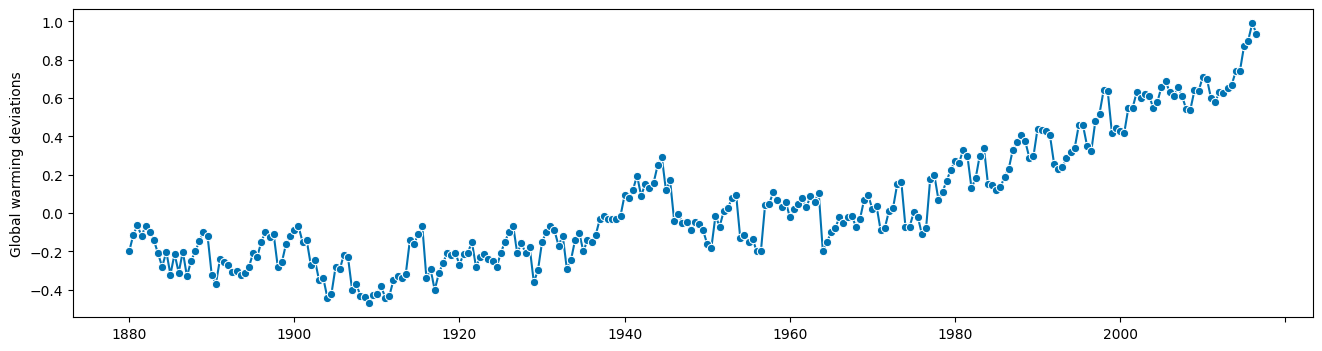

In [3]:
global_warming = pd.read_csv('..\data\\global_warming_deviations.csv', index_col=0)
global_warming = pd.Series(global_warming['Global warming deviations'])
plot_series(global_warming)
plt.show()

3. **Marketing time series**

A problem of interest in commerce is the analysis of sales in successive days, weeks or months. Knowing past sales can help to forecast or estimate the number of future sales to prepare the warehouse or prepare budgets.

The time series below corresponds to the sales volumes of anti-diabetic drugs in Australia, collected by month. The data were used to forecast the annual budget for the Pharmaceutical Benefit Scheme (PBS) by the Australian Government.

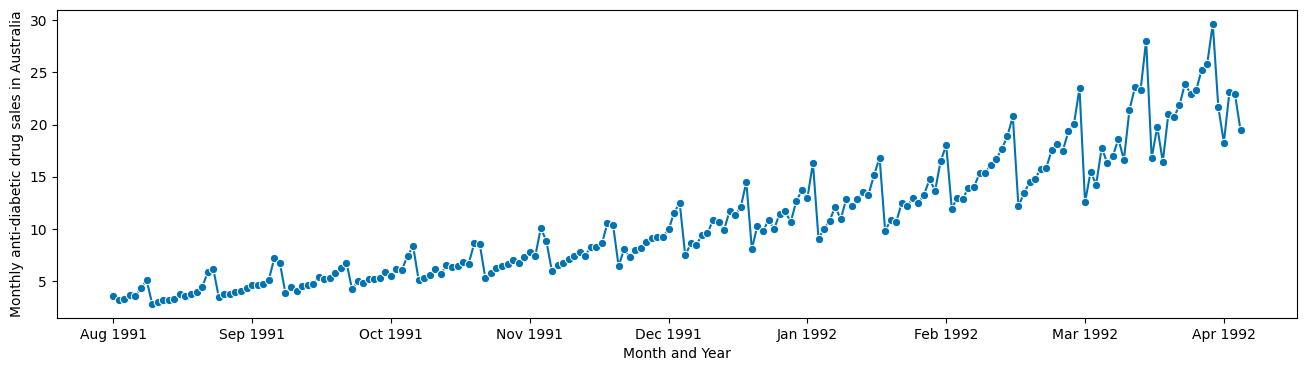

In [4]:
antidiabetic_sales = pd.read_csv('..\data\Monthly_anti-diabetic_drug_sales_in_Australia_from_1991_to_2008.csv', index_col=0, parse_dates=['Date'])
antidiabetic_sales = pd.Series(antidiabetic_sales['Monthly anti-diabetic drug sales in Australia'])
fig, ax = plot_series(antidiabetic_sales)
ax.set_xticklabels(antidiabetic_sales.index.strftime('%b %Y'))
ax.set_xlabel('Month and Year')
plt.show()

----------------------------------------------------------------


# Objectives of time series analysis<a class="anchor" id="chapter3"></a>

The first step in a time series analysis is to define the problem to be solved. This includes stating what the objective of the analysis is and what it is intended to solve.

1. **Description:** The first step of a time series analysis is to **plot** the series and find its main characteristics: **trend, seasonal patterns, outliers**. Outliers (values that do not appear to be consistent with the rest of the observations) may simply be extreme values that indicate that the distribution of the data is not normal; or they may be measurement errors, in which case they should be adjusted before any analysis.
This identification phase can help to decide whether the variation of a time series can be well represented by the combination of simple patterns or whether a more complex model is needed.

2. **Explanation:** When two or more variables are observed, it may be possible to use the variation in one time series to **explain the variation** in another. This could lead to a better **understanding** of the mechanism that produced a given time series. The application of explainable methods or models, such as multiple regression, is essential: if the objective is to explain the relationship between time series, models such as neural networks are ruled out. For example, it may be of interest to study how sales are affected by price and economic conditions.

3. **Forecast:**  Given an observed time series, one may want to predict the future values of the series. Predicting certain things is simpler than others. Tomorrow morning's sunrise timing can be predicted with accuracy. The lottery numbers for tomorrow, however, cannot be predicted with any degree of accuracy. The degree to which an event or amount is predictable relies on a number of variables, including: 
    - how effectively we comprehend the contributing components; 
    - the amount of data that is obtainable; 
    - and whether or not the forecasts can influence the thing that we are seeking to forecast

4. **Control:** The goal of the analysis may be to control the process when a time series is created to gauge the effectiveness of a manufacturing process. In order to keep the process on track, a stochastic model is fitted to the series, future values of the series are predicted, and the input process variables are adjusted so as to keep the process on target.

-----------------------------------

# Classification of time series<a class="anchor" id="chapter4"></a>

## Univariate or Multivariate time series

The previous series were examples of **univariate** series, the simplest form of time series. Sometimes it is more convenient to add information from predictors related to the output variable to better describe or predict it. This is known as **multivariate** time series and an example is shown below.

**Multivariate US consumption expenditure series**

If you want to predict US consumption expenditure, you can use quarterly percentage changes in industrial production and personal savings as well as the unemployment rate, which may be related to the first one.

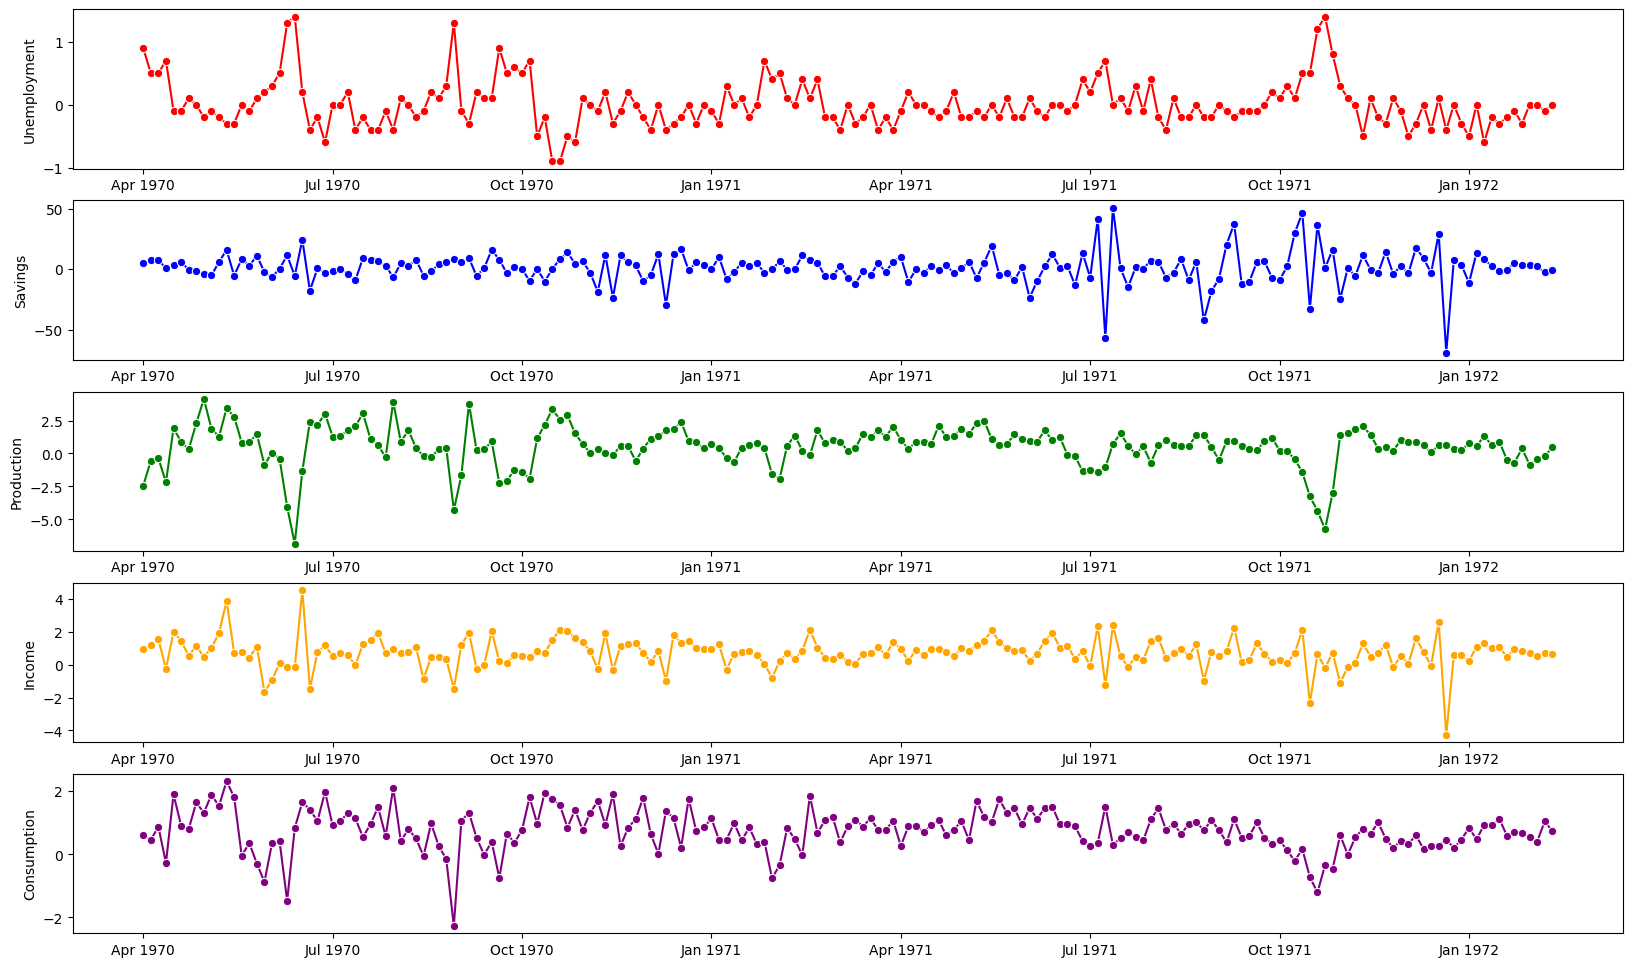

In [5]:
uschange = pd.read_csv('..\data\\uschange.csv', index_col=['Date'])

fig, ax = plt.subplots(5, 1, figsize=(20, 12)) # define figure with subplots
colors = ['red', 'blue', 'green', 'orange', 'purple'] # define list of colors

# decompose the multivariate series into univariate series and plot them
for variable in uschange.columns:
    uschange[variable] = pd.Series(uschange[variable])
    uschange[variable].index = pd.to_datetime(uschange[variable].index)
    # plot the series in the same figure with same format as above figures in subplot
    plot_series(uschange[variable], ax=ax[uschange.columns[::-1].get_loc(variable)])

# change color of each subplot line
for i in range(5):
    ax[i].lines[0].set_color(colors[i]) 
    # set xticklabels to be month and year
    ax[i].set_xticklabels(pd.to_datetime(uschange.index).strftime('%b %Y'))
   
plt.show()


## Other classifications

- A time series is said to be **continuous** when observations are made continuously in time; and is **discrete** when observations are taken only at specific times, usually equally spaced. A continuous time series can be transformed to a discrete time series by taking its values ar equal intervals of time (**sampled** series) or by **aggregating** (accumulating) the values over equal intervals of time.

- When successive observations are dependent, future values may be predicted from the past ones. If a time series can be predicted exactly (in a closed form by means of a mathematical expression), it is said to be **deterministic** (unfortunately, this is not usually the case). Most time series are **stochastic**: the future is only partially determined by past values, so it is impossible to provide accurate predictions and must be replaced by the idea that future values follow a probability distribution conditional on knowledge of past values. 

-------------------------------------------------

# Simple descriptive techniques<a class="anchor" id="chapter5"></a>

Traditionally, classical methods of time series analysis consider a time series as the decomposition into three components: 

$
\begin{equation}
Y_t = \mu_t + S_t + \varepsilon_t ,
\end{equation}
$
 
where $\mu_t$ is the trend, $S_t$ the seasonal pattern and $\varepsilon_t$ the remaining irregular fluctuations that cannot be explained by the previous ones. The trend is fitted by a polynomial curve and the seasonal part -if any- by a Fourier series. Subsequently, forecasts are generated by projecting the fitted functions.
This decomposition is not necessarily unique and does not usually give good results -although when the series is dominated by a strong trend or seasonal pattern, it may be useful to consider it. 

The patterns can be informally defined as follows:

- <span style="color:orange">Trend</span>: Intuitively, the trend of a time series can be defined as a smooth and progressive change in its long-term mean. The trend in a time series can be stochastic or deterministic. The latter is given when there is a physical explanation that generates the phenomenon, in which case it is of interest to model it with some deterministic method. In general, the latter is
is not realistic and local trends are usually studied. When studying a time series with a trend, two approaches can be distinguished.
The choice depends on the objective of the analysis: to estimate the trend or to remove it from the trend in order to study the structure of other local components such as seasonal patterns.
- <span style="color:orange">Seasonal patterns</span>:  A time series is said to exhibit a seasonal pattern of fixed period $s$ when it exhibits a similar periodic behaviour every $s$ time steps. 
- <span style="color:orange">Cyclical changes</span>: A cycle occurs when the data exhibit rises and falls that are not of a fixed frequency. These fluctuations are usually due to economic conditions, and are often related to the "business cycle". The duration of these fluctuations is usually at least 2 years. In many cases the difference in seasonal vs cyclical behavior can be known or measured with reasonable accuracy by looking at the regularity of the peaks in your data and looking for a drift the timing peaks from the mean distance between them. A series with strong seasonality will show distinct peaks in both the <span style="color:orange">partial autocorrelation function and the autocorrelation function</span>, while a cyclic series will show strong peaks only in the autocorrelation function. However, if you don't have enough data to determine this, or if the data is so noisy that measurement becomes difficult, the best way to determine whether the behavior is cyclical or seasonal is to consider the causes of data variability. Dates may be seasonal if the cause is directly related to time. On the other hand, if the reason is based on previous values ​​of the series and not directly on time, the series is likely to be cyclical (e.g. if the value of a stock increases, this gives the market confidence so more people invest, prices rise and vice versa, so the stock exhibits a cyclical pattern).
- <span style="color:orange">Remaining irregular fluctuations</span> not explained by the previous patterns: After having identified and removed the trend part and seasonal or cyclical variations, there remains a series of residuals that may or may not be random. If the residuals are random, then all the behaviour of the series is explained by its main patterns; if not (the most common case), then a model capable of modelling this information must be sought. 

## Example
To illustrate pattern identification and classical decomposition into components we use the passenger series. The original series is divided into a trend, a seasonal part and an irregular component.

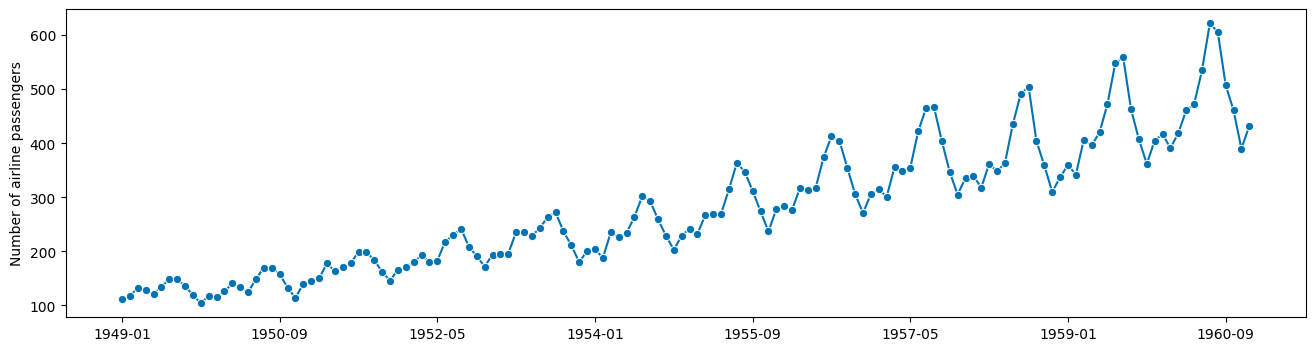

In [6]:
y = load_airline()
plot_series(y)
plt.show()

The series shows a clear upward trend over time and a multiplicative (the amplitude of the pattern expands with the trend) seasonal pattern (repetition of the shape of the series every 12 points).

More specifically, the period of the seasonal pattern can be identified using the **autocorrelation** and **partial autocorrelation** plots. Spectrograms and FFT are also useful. 

### ACF and PACF plots<a class="anchor" id="section5_2"></a>

<span style="color:orange">Autocorrelation</span>, also known as serial correlation, is the correlation of a signal with a delayed copy of itself as a function of the delay. Informally, it is the similarity between observations as a function of the time lag between them. Autocorrelation is a correlation coefficient. However, instead of correlation between two different variables, the correlation is between two values of the same variable at times $t$ and $t+k$.
This is, autocorrelation gives you an idea of how data points at different points in time are linearly related to one another as a function of their time difference. 
The correlogram, autocorrelation plot or ACF is a plot where values of autocorrelation of each lag are plotted against the lag. The interpretation of these graphs is not always easy, but in general terms the following can be said:
- If a time series is random and and the number of available observations is sufficiently large, the autocorrelation values are all near zero. It may happen that some value stands out for some lag $k$ and is a little higher than zero, but this should not be taken into account.
-  Stationary time series (defined later) often exhibit short-term correlation characterized by a fairly large value of the first autocorrelation value followed by a few further coefficients which, while greater than zero, tend to zero rapidly. Autocorrelation values for longer lags tend to be near zero. 
- Trending (non-stationary) series have slowly decaying autocorrelation values that do not approach zero until some large values of the lag. This is because an observation on one side of the overall mean tends to be followed by a large number of further observations on the same side of the mean because of the trend. Little can be inferred from a correlogram of this type as the trend dominates all other features. In fact the <span style="color:yellow">autocorrelation function is only meaningful for stationary time series (trend should be removed before calculating it)</span>. 
- If a time series contains a seasonal fluctuation, then the correlogram will also exhibit an oscillation at the same frequency. If the series follows a sinusoidal pattern, so does the autocorrelation values. If the seasonal variation is removed from seasonal data, then the correlogram may provide more useful information. 
- If a series contains outliers, then the correlogram may be seriously affected: it may be <span style="color:yellow">advisable to adjust outliers in some way before starting the formal analysis</span>. 

The <span style="color:orange">partial autocorrelation</span> of a time series for a given lag is the partial correlation of the time series with itself at that lag given all the information between the two points in time. It means you need to compute a number of conditional correlations and subtract these out of the total correlation. 

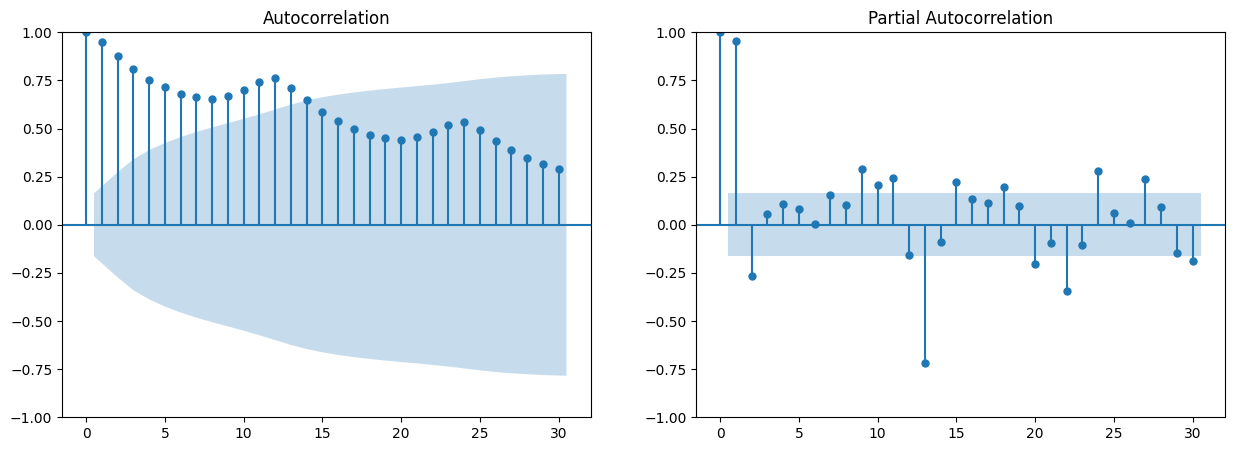

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(y, lags=30, ax=ax[0])
plot_pacf(y, lags=30, ax=ax[1])
plt.show()

Autocorrelation plot or ACF shows that there are many statistically significant lags (above the confidence intervals) and that the autocorrelation functions slowly decay into this shaded area. This is indicative of a trend in the time series. On the other hand, significant peaks are seen every 12th period (multiples of 12), which means that there is a seasonal pattern in the 12th period series.

The partial autocorrelation plot or PACF is useful for identifying the order of ARIMA models. In this case, two significant lags in the PACF are found.

### Decomposition<a class="anchor" id="section5_3"></a>

Finally, we will isolate the different components of a time series. This was the traditional approach, but not the most recommendable one in general; often this is done to help improve understanding of the time series. Different decomposition methods are: classical decomposition, X11 decomposition, SEATS decomposition and STL decomposition <span style="color:grey">(see [Time series decomposition](https://otexts.com/fpp2/decomposition.html) for details) </span>. 

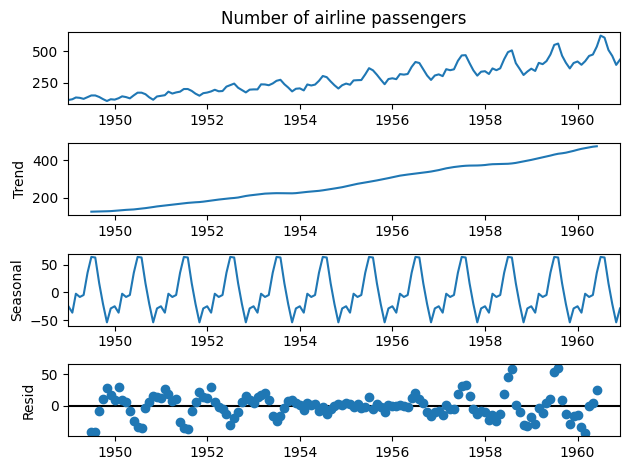

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# set frequency on data
y = y.to_timestamp()
# decompose the series into trend, seasonal and residual
res = seasonal_decompose(y).plot()
plt.show()

The series of residuals does not appear to be random, with a <span style="color:red">non-random pattern</span> at the beginning and end. This indicates that a more suitable model capable of picking up this pattern, which the classical decomposition cannot, could be sought. However, we can appreciate the upward trend and a clear seasonal pattern of period 12 (anual). 

-----------------------------------
# Stationary time series<a class="anchor" id="chapter6"></a>

The idea behind the concept of **stationarity** is that the probability laws governing the behaviour of a stochastic process do not vary over time, implying that there will be no changes in its mean or variance and that periodic variations, if any, will have been eliminated.
In a sense, <span style="color:green">a stationary process is in statistical equilibrium</span>:
- A stationary time series is one whose properties do not depend on the time at which the series is observed.
- Time series with trends, or with seasonality, are not stationary.
- Graphically, a stationary time series is a horizontal series with constant variance around its mean.

Most probability models require stationary time series, for example the models of the ARIMA family. It is therefore necessary to identify whether a series is stationary, and if the model requires it, to convert the non-stationary series into a stationary one. 
The stationarity of a series can be checked by graphical inspection or by statistical tests. 

## Tests for checking stationarity<a class="anchor" id="section6_1"></a>

To check the stationarity of the timeseries, two statistical tests are carried out in parallel:
1. **Augmented Dickey Fuller (ADF) test**: this test is used determine whether a unit root exists in a series, and thus helps to understand whether the series is stationary. 
    - Null Hypothesis: The series has a unit root (timeseries is **not** stationary).
    - Alternate Hypothesis: The series has no unit root (timeseries is stationary).
    - Results: If p-value of the test is less than significance level (p-value<$\alpha$ = 0.05), then the null hypothesis is rejected and infers that timeseries is stationary. If p-value>$\alpha$, the timeseries is not stationary and a differentiation order must be found.

2. **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**: another test to check the stationarity of time series. The hypothesis for this test are opposite that of the ADF test.
    - Null Hypothesis: The process is trend stationary.
    - Alternate Hypothesis: The series has a unit root (series is not stationary).
    - Results: If p-value of the test is less than significance level (p-value<$\alpha$ = 0.05), then timeseries is not stationary. If p-value>$\alpha$, the timeseries is stationary and a differentiation order must be found.

Results must be interpreted as follows:
- Case 1: Both tests conclude that the series is not stationary - The series is not stationary
- Case 2: Both tests conclude that the series is stationary - The series is stationary
- Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.


## Tests for checking seasonal stationarity<a class="anchor" id="section6_2"></a>
To check the seasonal stationarity of the timeseries, two statistical tests are carried out in parallel:
1. **Osborn-Chu-Smith-Birchenhall (OCSB) test**: test for seasonal unit root roots in a time series. Determines whether it needs seasonal differencing. The hypothesis are:
    - Null Hypothesis: the series contains a seasonal unit root (timeseries is not seaonal stationary).
    - Alternate Hypothesis: the series does not contain a seasonal unit root (timeseries is seasonal stationary).

2. **Canova-Hansen (CH) test**: test for seasonal differences. 
    - Null Hypothesis: the seasonal pattern is stable over time
    - Alternate Hypothesis: the seasonal pattern is unstable over time

## Example: White noise series<a class="anchor" id="section6_3"></a>
An important example of a stationary series is the white noise series, whish is defined as a sequence of independent, identically distributed random variables. It is usually assumed that the white noise process has mean zero and variance $\sigma_{\varepsilon}^2$. 

This is represented below (as a line plot and as a scatter plot) to show how the values of the series are distributed around a fixed mean (zero) and the variance is constant (one) around this mean.

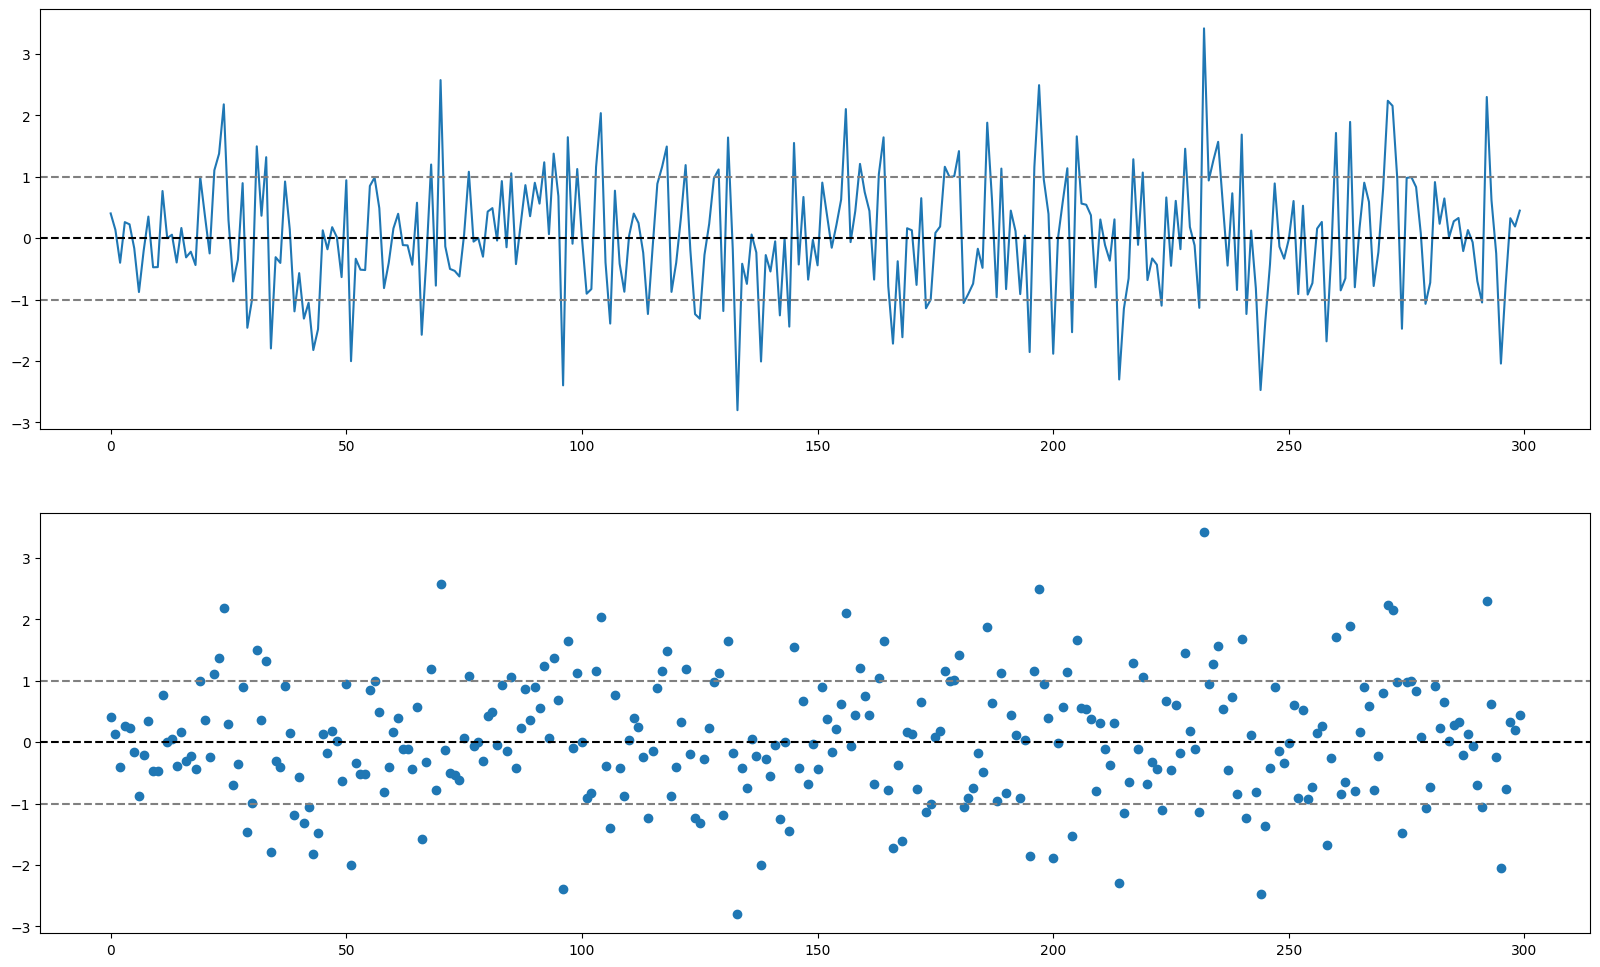

In [9]:
from random import gauss
from random import seed

from matplotlib import markers

# seed random number generator
seed(123)
# define white noise white_noise with 300 points
white_noise = [gauss(0.0, 1.0) for i in range(300)]
white_noise = pd.Series(white_noise)
# define subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 12))
# plot the white_noise as a line
axs[0].plot(white_noise)
# plot the white_noise as dots
axs[1].scatter(white_noise.index, white_noise.values)

# add the mean line
for i in [0,1]:
    # add a horizontal dashed line at zero
    axs[i].axhline(y=0, color='black', linestyle='--')

    # add two horizontal dashed lines at -1 and 1
    axs[i].axhline(y=-1, color='grey', linestyle='--')
    axs[i].axhline(y=1, color='grey', linestyle='--')
plt.show()

# uncomment lines below to inspect the histogram and autocorrelation plot
# # histogram plot
# white_noise.hist()
# plt.show()

# # autocorrelation
# pd.plotting.autocorrelation_plot(white_noise)
# plt.show()

In [10]:
# check stationarity with tests
from utils import adf_test, kpss_test
adf_test(white_noise, print_only_result=False)
kpss_test(white_noise, print_only_result=False)


ADF Test Results
-----------------
ADF Statistic: -16.15800441896372
p-value: 4.4967281031066644e-29
num lags: 0
Critical Values:
	1% : -3.4524113009049935
	5% : -2.8712554127251764
	10% : -2.571946570731871
Result: The timeseries is stationary

KPSS Test Results
-----------------
KPSS Statistic: 0.07664041494461968
p-value: 0.1
num lags: 3
Critical Values:
	10% : 0.347
	5% : 0.463
	2.5% : 0.574
	1% : 0.739
Result: The timeseries is stationary


Ideally, residuals after a model has been fitted on a time series should look like above: uncorrelated, around a zero mean and with little standard deviation. 

On the other hand, if a time series is like this, it means that no model will be able to provide good predictions, as the data are random. Before starting the analysis it is therefore important to <span style="color:orange">make sure that the series is predictable by checking that it is not white noise</span> -and after fitting a model, check that the residues are white noise as well.-. After having visualised the series (which provides clues to infer this), statistical tests can be carried out to determine this:

<a class="anchor" id="section6_3_1"></a>
- **Ljung-Box Test:** determines whether or not data points are white noise or not (i.e. presence of significant autocorrelation).
    - Null Hypothesis: the series are independently distributed
    - Alternate Hypothesis: the series are not independently distributed

In [11]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(white_noise,lags=None,  return_df=True)

,lb_stat,lb_pvalue
1,1.251331,0.263298
2,1.258749,0.532925
3,2.436801,0.486821
4,2.472126,0.649634
5,6.364101,0.272384
6,6.820363,0.337780
7,6.860500,0.443548
8,7.114137,0.524370
9,7.298004,0.606123
10,7.360113,0.691067


The test statistic for the first lag is 1.251331 and the p-value is 0.263298>0.05, so we can accept the null hypothesis that the residuals at lag 1 are independently distributed. The same can be said for lags up to 10. 

-------------------------------
# Normality<a class="anchor" id="chapter7"></a>

Finally, <span style="color:orange">the assumptions of the models to be used should always be taken into account</span>. Some models require stationarity, other models require normality in the distribution of the data. A statistical test used to check whether the data are normal is the Shapiro test:

<a class="anchor" id="section7_1"></a>
- **Shapiro test**: used to assess whether the series is normally distributed.
    - Null Hypothesis: The series is normally distributed. 
    - Alternate Hypothesis: The series is not normally distributed. 

In [12]:
from scipy.stats import shapiro
shapiro(white_noise)

ShapiroResult(statistic=0.9972317814826965, pvalue=0.8924189209938049)

The p-value is 0.98>0.05, so we can conclude that the series is normally distributed. 

--------------------------
# Transformations<a class="anchor" id="chapter8"></a>

Sometimes a time series can be transformed to obtain an equivalent version of the same time series with more appropriate properties. For example, to make it stationary or normal. Some of the most common transformations are outlined below together with the main reasons for transforming a series.

<a class="anchor" id="section8_1"></a>
1. **To stabilize the variance:** If there is a trend in the series and the variance seems to increase with the mean, then it might be advisable to transform the data. In particular, a <span style="color:orange">log transformation</span> is indicated when the standard deviation is proportional to the mean.

2. **To make the seasonal effect additive:** If there is a trend in the series and the magnitude of the seasonal effect appears to increase as the mean increases, it is recommended to transform the data so that the seasonal effect remains constant from year to year. Seasonal effects are then called **additive** effects. In particular, seasonal effects are said to be **multiplicative** when their magnitudes are proportional to the mean, and <span style="color:orange">log transformations</span> are suitable for adding effects. However, <span style="color:brown">this transformation only stabilizes the variance if the error term is also assumed to be multiplicative</span>.

3. **To make a quadratic trend linear:** If a time series contains a quadratic trend, it can be made linear taking the <span style="color:orange">square root</span>. 

4. **To make the data normally distributed:** Modeling and forecasting are usually done under the assumption that the data are normally distributed. In practice, this is not necessarily the case; for example, it might indicate skew by the spikes on the time plot all pointing in the same direction (up or down). This effect can be difficult to eliminate and may require different error distributions to be assumed. Logarithmic and square root transformations are special cases of a class of transformations called <span style="color:orange">Box-Cox transformations</span>. Given an observed time series $\{y_t\}$ and a transformation parameter $\lambda$, the transformed series $\{z_t\}$ is given by:
$
\begin{equation}
z_t = \begin{cases}\left(y_t^\lambda-1\right) / \lambda & \lambda \neq 0 \\ \log y_t & \lambda=0\end{cases}
\end{equation}
$
This is effectively just a power transformation when $\lambda \neq 0$. The best value of $\lambda$ can be guesstimated, or alternatively estimated by a proper inferential procedure, such a maximum likelihood.
In practice, there are problems with transformations, for example, transformations that add seasonal effects may not stabilize the variance and do not satisfy all requirements at the same time. In any case, a model built for the transformed data won't help. For example, predictions made from a transformed model may need to be back-transformed, which can lead to bias effects. A recommendation is to avoid transformations wherever possible except where the transformed variable has a direct physical interpretation (when percentage increases are of interest, then taking logarithms makes sense).

- <span style="color:red">Notes: 
    - log and square root transformations are used to reduce the variance of variance over time.
    - To apply these transformations, data must be positive. If it is not the case and you choose to shift your data before operating, you are adding bias. 
    - In addition, taking square root or log is the same as compressing the space between larger values but not between smaller values, so you make larger values less dissimilar from one another and minimize the distinctions among outliers </span>

### Implementation

First, the log transform is applied to the example airline passenger series. It can be observed that the seasonal effect is now additive and the trend is conserved. 

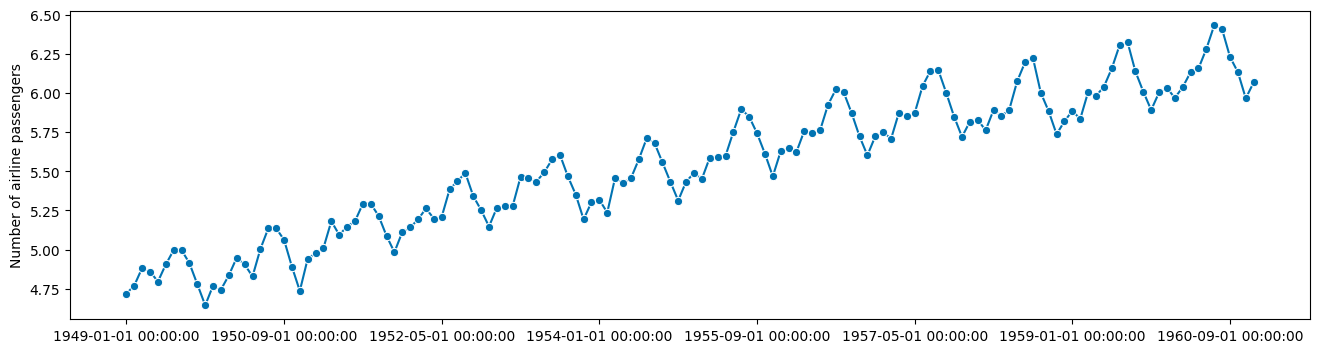

In [13]:
# apply log transform to y
y_log = np.log(y)
# plot the series
plot_series(y_log)
plt.show()

Box-cox transformation is applied now. The implementation below finds the best value for the $\lambda$ parameter and apply the transformation. The  $\lambda$ value in this case is close to zero, i.e., a log transform is suggested.

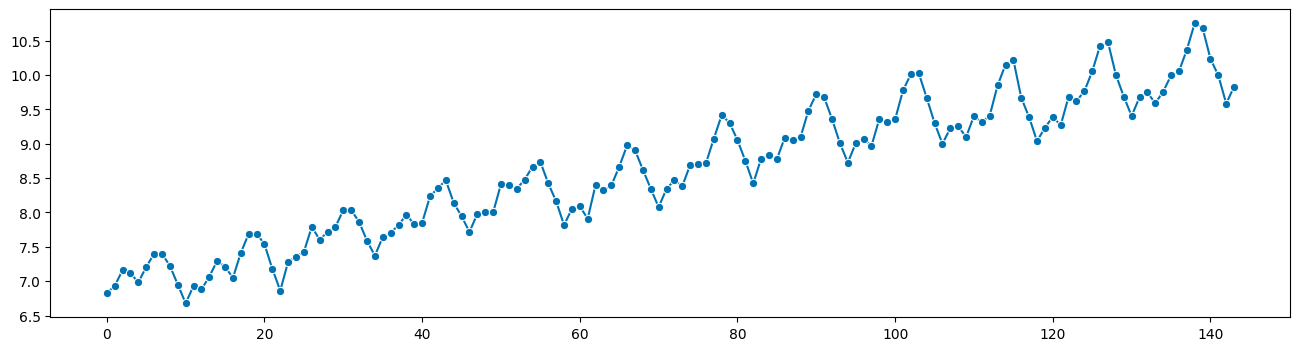

lambda: 0.14802265137037945


In [14]:
from scipy.stats import boxcox
# apply box-cox transformation
y_boxcox, l = boxcox(y)
# plot the series
plot_series(pd.Series(y_boxcox))
plt.show()
# check parameter lambda
print('lambda:', l)

## Filters<a class="anchor" id="section8_2"></a>

Two filters are now presented that should be applied when seasonal patterns are noise and not a feature of the series or when it is desired to remove the trend from a series in order to study other patterns. 

1. **Simple moving average:** When a time series has local fluctuations or seasonal patterns that are not to be considered in the analysis (they are noise), these can be smoothed using a linear filter called a moving average, which estimates the local average of the series:
$\text{SMA}_q\left(y_t\right)-\frac{1}{q} \sum_{r=0}^{q-1} y_{t+r}
$. In general, it is not recommended to use this filter to estimate the trend, but rather 
<span style="color:orange"> to reduce the effect of random noise or eliminate seasonal variation</span>. The new series contains $q-1$ values. With seasonal data, it is a good idea to start by calculating moving averages using windows of period equal to the seasonal one as these will provide a simple description of the underlying trend.

2. **Differencing:** This filter is used <span style="color:orange">to remove the trend</span> from a time series and consists of deferencing the time series until it becomes stationary: $\nabla y_t = y_t - y_{t-1}$. Note that the transformed series will have $n-1$ observations. Each observation of the differenced series represents the change that occurs between each pair of consecutive observations of the original series. This filter is of particular importance in ARIMA family models <span style="color:orange">to convert a non stationary series into a stationary one</span>. In particular, if the trend of a time series is a polynomial of order $d$, $d$ differentiations are needed to remove it and make the series stationary.

### Implementation

First the moving average filter is applied to the series. It can be seen that the seasonal pattern is smoothed and the trend is now easier to observe. The first 11 (12-1) values are NaN values.

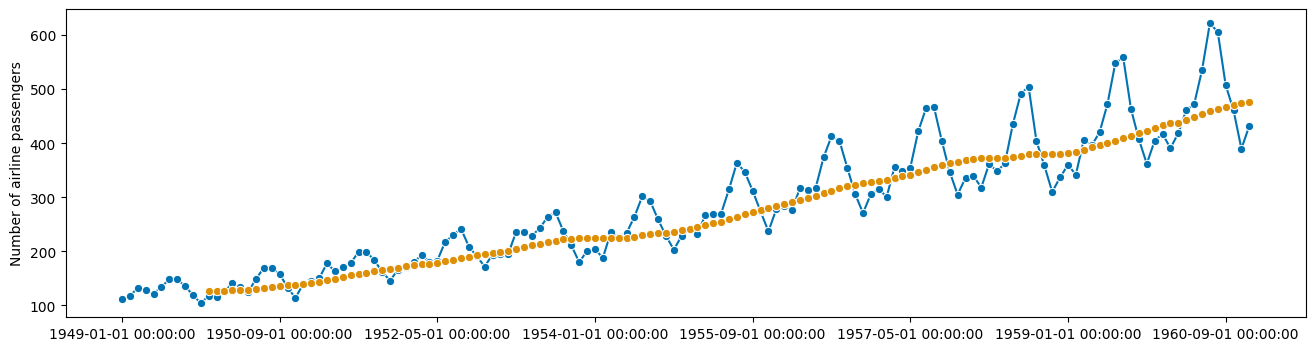

In [15]:
# moving average filter with window=seasonal period and taking the mean
ma_y = y.rolling(window=12).mean()
# plot series
plot_series(y, ma_y)
plt.show()

We now see what happens when we apply a differentiation to the series:

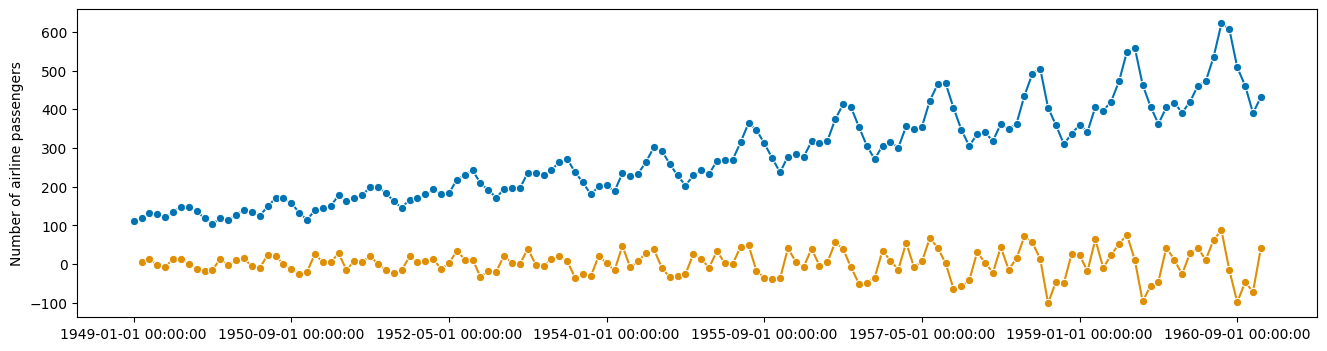

In [16]:
# difference once the series
y_diff = y.diff()
# plot series
plot_series(y, y_diff)
plt.show()

The trend disappears and the values of the series are distributed around zero. The variance of the series appears to be non-constant. To convert the series into a more stationary version, let us take the logarithm of the original series and differentiate:

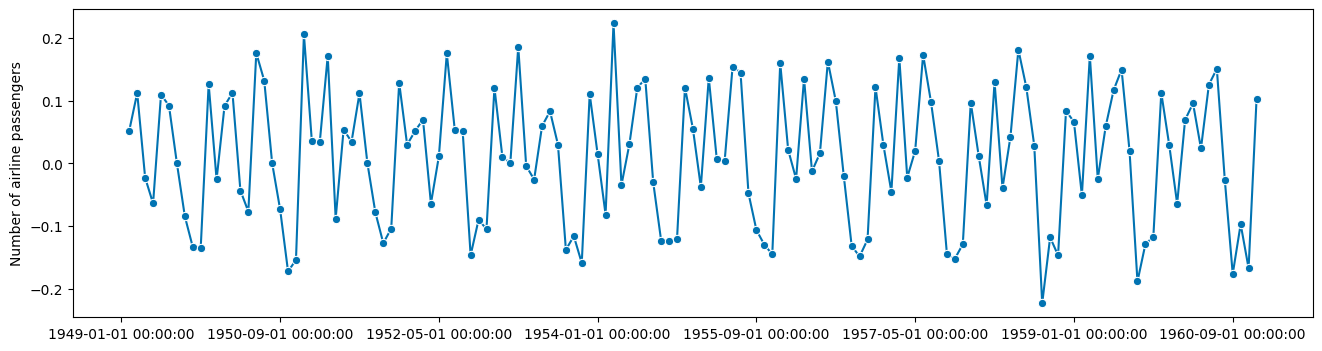

In [17]:
# difference the logarithmic series
y_log_diff = y_log.diff()
# plot series
plot_series(y_log_diff)
plt.show()

Now the series varies around zero with constant variance. Graphically it appears stationary.

------------------------

# Summary<a class="anchor" id="summary"></a>

A time series is a set of observations ordered and indexed over time. Time series are particularly important in economics, marketing, etc.
The concept of order in the observations means that both the treatment of the data and the identification of relevant patterns and the subsequent modelling and prediction differ significantly from a normal supervised problem. 

One of the first steps in a time series analysis is to identify the objective to be achieved. It usually starts with the description of the observations (identifying relevant patterns -trend, seasonality, outliers-). If you have two or more variables, you may want to explain the relationship between them. However, the most common objective is to predict the future values of a series, if the series is predictable and if sufficient observations are available. 

There are several classifications for time series: univariate (a single time series) or multivariate (several time series affecting one another), continuous (observations recorded continuously over time) or discrete (observations taken at specific equispaced time instants), deterministic (can be expressed as a mathematical function exactly) or stochastic (values are partially determined by past values).

The patterns that can be found in a time series have been introduced: trend, seasonal patterns, cyclical changes and the irregular part. In order to identify them, it is useful, first of all, to represent the series and then to study other graphs such as the autocorrelation graph. 

An important type of time series are stationary time series, which are those that are in a statistical equilibrium (constant mean and variance). In addition, a very important stationary process has been defined: white noise. Statistical tests have been defined that are quite relevant to start a time series analysis: the Ljung-Box test to ensure that the series is not white noise and can be predicted, ADF and KPSS tests to check the stationarity of a series or the Shapiro test to verify if it is normal.

Finally, useful transformations (logarithmic or Box-Cox) and filters (simple moving average or differencing) that are commonly used are proposed. 
 